# Porter: Neural Networks Regression

Porter is India's Largest Marketplace for Intra-City Logistics. Leader in the country's $40 billion intra-city logistics market, Porter strives to improve the lives of 1,50,000+ driver-partners by providing them with consistent earning & independence. Currently, the company has serviced 5+ million customers

**Problem Statement**: Porter works with restaurants for food delivery. It wants to give its customers an accurate estimate of the delivery time based on factors like the order time, items ordered, availability of delivery partners, number of outstanding orders and the type of restaurant. We need to build a regression model to predict the delivery time as accurately as possible based on these features.


Each row in this file corresponds to one unique delivery. Each column corresponds to a feature as explained below.

1. market_id : integer id for the market where the restaurant lies
2. created_at : the timestamp at which the order was placed
3. actual_delivery_time : the timestamp when the order was delivered
4. store_primary_category : category for the restaurant
5. order_protocol : integer code value for order protocol(how the order was placed ie: through porter, call to restaurant, pre booked, third part etc)
6. total_items subtotal : final price of the order
7. num_distinct_items : the number of distinct items in the order
8. min_item_price : price of the cheapest item in the order
9. max_item_price : price of the costliest item in order
10. total_onshift_partners : number of delivery partners on duty at the time order was placed
11. total_busy_partners : number of delivery partners attending to other tasks
12. total_outstanding_orders : total number of orders to be fulfilled at the moment

# Loading the Dataset

In [85]:
!pip install category_encoders --quiet

In [86]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.layers import Dropout


# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [87]:
df = pd.read_csv('/content/drive/MyDrive/Projects/Porter/porter dataset.csv')
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 196441 non-null  float64
 1   created_at                197428 non-null  object 
 2   actual_delivery_time      197421 non-null  object 
 3   store_id                  197428 non-null  object 
 4   store_primary_category    192668 non-null  object 
 5   order_protocol            196433 non-null  float64
 6   total_items               197428 non-null  int64  
 7   subtotal                  197428 non-null  int64  
 8   num_distinct_items        197428 non-null  int64  
 9   min_item_price            197428 non-null  int64  
 10  max_item_price            197428 non-null  int64  
 11  total_onshift_partners    181166 non-null  float64
 12  total_busy_partners       181166 non-null  float64
 13  total_outstanding_orders  181166 non-null  f

In [89]:
df.shape

(197428, 14)

# Data Preprocessing

Lets check the number of unique values in each column so that we can identify categorical features

In [90]:
df.nunique(axis=0)

market_id                        6
created_at                  180985
actual_delivery_time        178110
store_id                      6743
store_primary_category          74
order_protocol                   7
total_items                     57
subtotal                      8368
num_distinct_items              20
min_item_price                2312
max_item_price                2652
total_onshift_partners         172
total_busy_partners            159
total_outstanding_orders       281
dtype: int64

Now, we will convert the datetime columns to their respective datatypes

In [91]:
df['created_at'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d %H:%M:%S')
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'], format='%Y-%m-%d %H:%M:%S')

## Feature Extraction

Taking the difference between the time of delivery and order creation time will give us our target variable, which is the delivery time in minutes

In [92]:
df['delivery_time'] = (df['actual_delivery_time']-df['created_at']).dt.total_seconds()/60

Extracting datetime features from the order creation timestamp

In [93]:
df['order_hour'] = df['created_at'].dt.hour
df['order_day'] = df['created_at'].dt.weekday

## Missing Values

In [94]:
df.isnull().sum()

market_id                     987
created_at                      0
actual_delivery_time            7
store_id                        0
store_primary_category       4760
order_protocol                995
total_items                     0
subtotal                        0
num_distinct_items              0
min_item_price                  0
max_item_price                  0
total_onshift_partners      16262
total_busy_partners         16262
total_outstanding_orders    16262
delivery_time                   7
order_hour                      0
order_day                       0
dtype: int64

Deleting all the rows with null values beacause they are not a large proportion of the dataset

In [95]:
df.dropna(inplace=True)
df.shape

(176248, 17)

In [96]:
#Converting required float columns to int datatype
float_cols = ['total_onshift_partners','total_busy_partners','total_outstanding_orders','order_protocol','market_id']
df[float_cols] = df[float_cols].astype('int')

Delete columns which are not required anymore

In [97]:
df.drop(columns=['store_id','created_at','actual_delivery_time'], inplace=True)

## Outlier Detection

In [98]:
#Understanding the range and spread of all the features
df.describe()

,market_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_time,order_hour,order_day
count,176248.000000,176248.000000,176248.000000,176248.000000,176248.000000,176248.000000,176248.000000,176248.000000,176248.000000,176248.000000,176248.000000,176248.000000,176248.000000
mean,2.743747,2.911687,3.204592,2696.498939,2.674589,684.937730,1159.886994,44.905276,41.845434,58.206800,47.764210,8.493872,3.221563
std,1.330911,1.512920,2.673899,1828.922584,1.625558,519.911425,560.784510,34.529394,32.154573,52.708344,27.654861,8.681474,2.041332
min,1.000000,1.000000,1.000000,0.000000,1.000000,-86.000000,0.000000,-4.000000,-5.000000,-6.000000,1.683333,0.000000,0.000000
25%,2.000000,1.000000,2.000000,1408.000000,1.000000,299.000000,799.000000,17.000000,15.000000,17.000000,35.083333,2.000000,1.000000
50%,2.000000,3.000000,3.000000,2221.000000,2.000000,595.000000,1095.000000,37.000000,35.000000,41.000000,44.366667,3.000000,3.000000
75%,4.000000,4.000000,4.000000,3407.000000,3.000000,942.000000,1395.000000,65.000000,62.000000,85.000000,56.366667,19.000000,5.000000
max,6.000000,7.000000,411.000000,26800.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,6231.316667,23.000000,6.000000


In [99]:
# Removing rows with negative values in the following list of columns
df = df[~((df[['total_onshift_partners','total_busy_partners','total_outstanding_orders','min_item_price']]<0).any(axis=1))]

We can further analyse columns like `total_items`, `subtotal`, `min_item_price`, `max_item_price`, `total_onshift_partners`,  `total_busy_partners`, `total_outstanding_orders` for outliers since some of their min values are  negative and others have abmormally high max values

In [100]:
df.describe()

,market_id,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_time,order_hour,order_day
count,176157.000000,176157.000000,176157.000000,176157.000000,176157.000000,176157.000000,176157.000000,176157.000000,176157.000000,176157.000000,176157.000000,176157.000000,176157.000000
mean,2.744109,2.911789,3.204079,2696.578484,2.674580,684.953814,1159.928195,44.923909,41.862940,58.233298,47.762546,8.492072,3.221598
std,1.330883,1.512871,2.671920,1829.049610,1.625497,519.832246,560.753666,34.527336,32.152557,52.707934,27.658504,8.681096,2.041356
min,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.683333,0.000000,0.000000
25%,2.000000,1.000000,2.000000,1408.000000,1.000000,299.000000,799.000000,17.000000,15.000000,17.000000,35.083333,2.000000,1.000000
50%,2.000000,3.000000,3.000000,2221.000000,2.000000,595.000000,1095.000000,37.000000,35.000000,41.000000,44.366667,3.000000,3.000000
75%,4.000000,4.000000,4.000000,3408.000000,3.000000,942.000000,1395.000000,66.000000,63.000000,85.000000,56.366667,19.000000,5.000000
max,6.000000,7.000000,411.000000,26800.000000,20.000000,14700.000000,14700.000000,171.000000,154.000000,285.000000,6231.316667,23.000000,6.000000


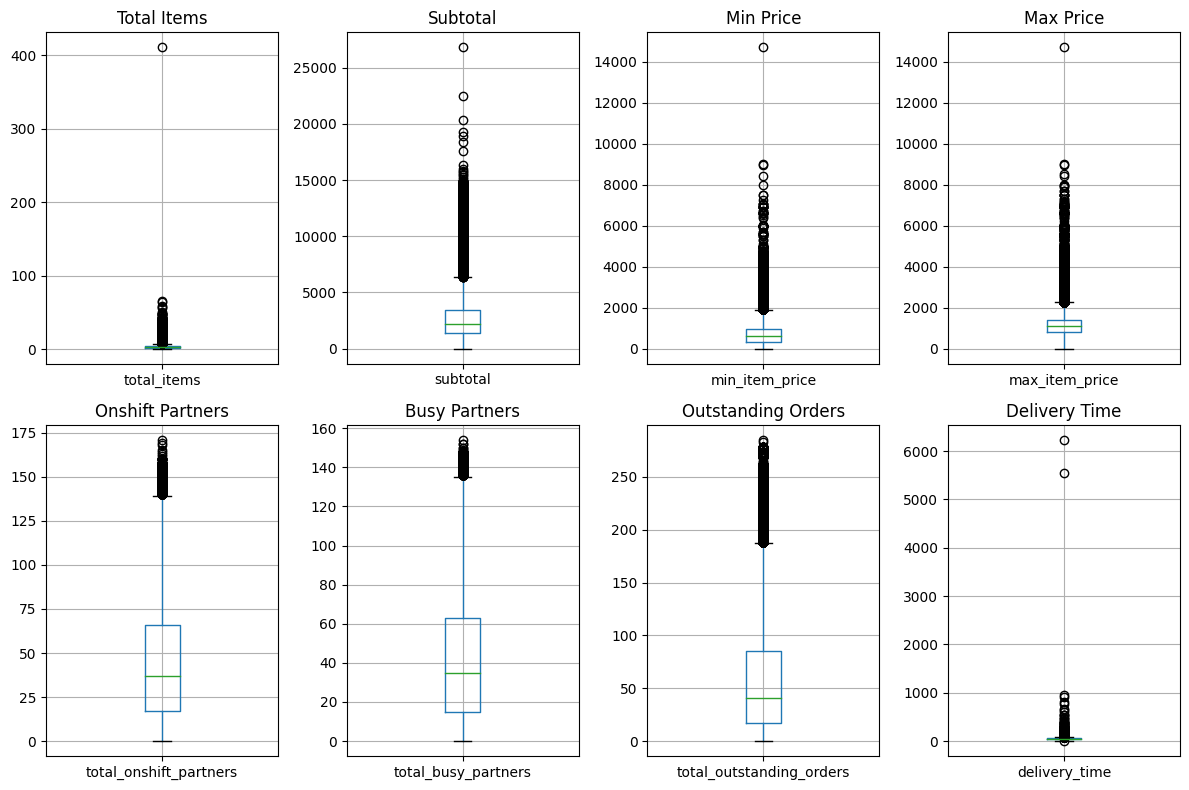

In [101]:
fig, ax = plt.subplots(2,4, figsize=(12,8))


df.boxplot(column='total_items', ax=ax[0,0])
ax[0,0].set_title('Total Items')

df.boxplot(column='subtotal', ax=ax[0,1])
ax[0,1].set_title('Subtotal')

df.boxplot(column='min_item_price', ax=ax[0,2])
ax[0,2].set_title('Min Price')

df.boxplot(column='max_item_price', ax=ax[0,3])
ax[0,3].set_title('Max Price')

df.boxplot(column='total_onshift_partners', ax=ax[1,0])
ax[1,0].set_title('Onshift Partners')

df.boxplot(column='total_busy_partners', ax=ax[1,1])
ax[1,1].set_title('Busy Partners')

df.boxplot(column='total_outstanding_orders', ax=ax[1,2])
ax[1,2].set_title('Outstanding Orders')

df.boxplot(column='delivery_time', ax=ax[1,3])
ax[1,3].set_title('Delivery Time')

plt.tight_layout()
plt.show()

In [102]:
# Remove outliers through IQR method
outlier_cols = ['total_items', 'subtotal', 'min_item_price',
                'max_item_price', 'delivery_time', 'total_onshift_partners',
                'total_busy_partners', 'total_outstanding_orders']

for col in outlier_cols:
  # Calculate Q1 and Q3
  q1 = np.percentile(df[col], 25)
  q3 = np.percentile(df[col], 75)

  # Calculate IQR
  iqr = q3 - q1

  # Define lower and upper bounds
  lower_bound = q1 - (1.5 * iqr)
  upper_bound = q3 + (1.5 * iqr)

  # Remove outliers
  df = df.loc[~((df[col] < lower_bound) | (df[col] > upper_bound))]

df.shape

(142433, 14)

In [104]:
# Replace min & max item price with average price
df['avg_item_price'] = (df['min_item_price']+df['max_item_price'])/2
df.drop(columns=['min_item_price','max_item_price'], inplace=True)

Descriptive stats after removal of negative values and outliers

In [105]:
df.describe()

,market_id,order_protocol,total_items,subtotal,num_distinct_items,total_onshift_partners,total_busy_partners,total_outstanding_orders,delivery_time,order_hour,order_day,avg_item_price
count,142433.000000,142433.00000,142433.000000,142433.000000,142433.000000,142433.000000,142433.000000,142433.000000,142433.000000,142433.000000,142433.000000,142433.00000
mean,2.757191,2.90948,2.743950,2271.489451,2.419425,40.451321,37.825630,50.109708,44.307581,9.192575,3.160489,854.23622
std,1.342240,1.51875,1.479029,1206.767735,1.251559,29.971476,28.286088,42.681239,14.252795,8.864070,2.021523,335.44342
min,1.000000,1.00000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,3.716667,0.000000,0.000000,46.50000
25%,2.000000,1.00000,2.000000,1318.000000,1.000000,16.000000,14.000000,16.000000,33.816667,2.000000,1.000000,612.00000
50%,2.000000,3.00000,2.000000,2000.000000,2.000000,34.000000,32.000000,37.000000,42.350000,4.000000,3.000000,820.00000
75%,4.000000,4.00000,4.000000,2991.000000,3.000000,59.000000,57.000000,75.000000,53.016667,20.000000,5.000000,1050.00000
max,6.000000,7.00000,7.000000,6067.000000,7.000000,134.000000,130.000000,174.000000,86.250000,23.000000,6.000000,2000.00000


# Exploratory Data Analysis

## Univariate Analysis

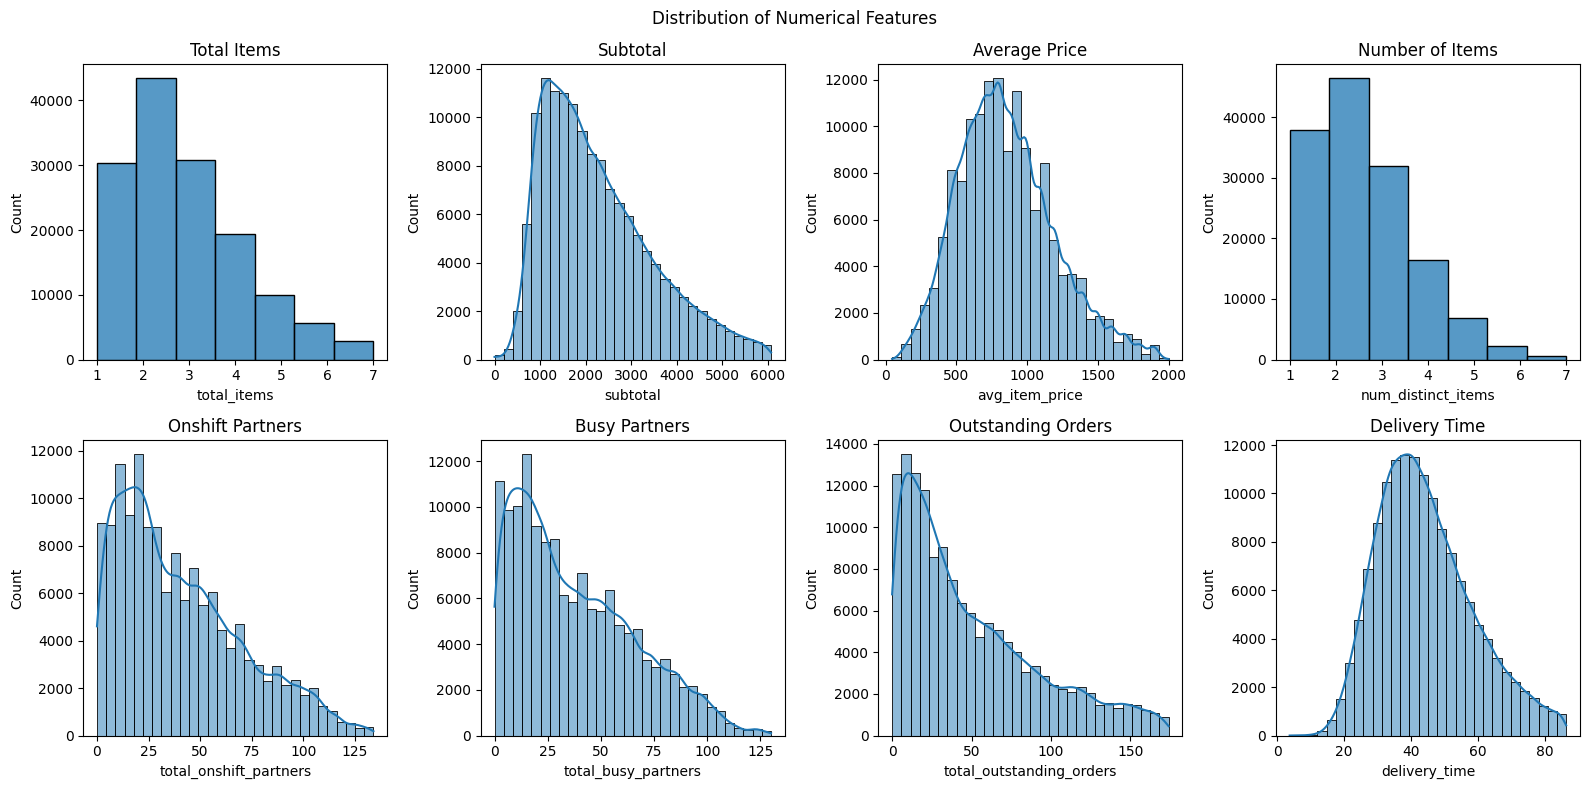

In [124]:
# Distribution of Numerical Features

fig, ax = plt.subplots(2,4, figsize=(16,8))
plt.suptitle('Distribution of Numerical Features')

sns.histplot(data=df, x='total_items', bins=7, ax=ax[0,0])
ax[0,0].set_title('Total Items')

sns.histplot(data=df, x='subtotal', bins=30, kde=True, ax=ax[0,1])
ax[0,1].set_title('Subtotal')

sns.histplot(data=df, x='avg_item_price', bins=30, kde=True, ax=ax[0,2])
ax[0,2].set_title('Average Price')

sns.histplot(data=df, x='num_distinct_items', bins=7, ax=ax[0,3])
ax[0,3].set_title('Number of Items')

sns.histplot(data=df, x='total_onshift_partners', bins=30, kde=True, ax=ax[1,0])
ax[1,0].set_title('Onshift Partners')

sns.histplot(data=df, x='total_busy_partners', bins=30, kde=True, ax=ax[1,1])
ax[1,1].set_title('Busy Partners')

sns.histplot(data=df, x='total_outstanding_orders', bins=30, kde=True, ax=ax[1,2])
ax[1,2].set_title('Outstanding Orders')

sns.histplot(data=df, x='delivery_time', bins=30, kde=True, ax=ax[1,3])
ax[1,3].set_title('Delivery Time')

plt.tight_layout()
plt.show()

It can be observed that all of the numerical features have a right skew due to presence of outliers

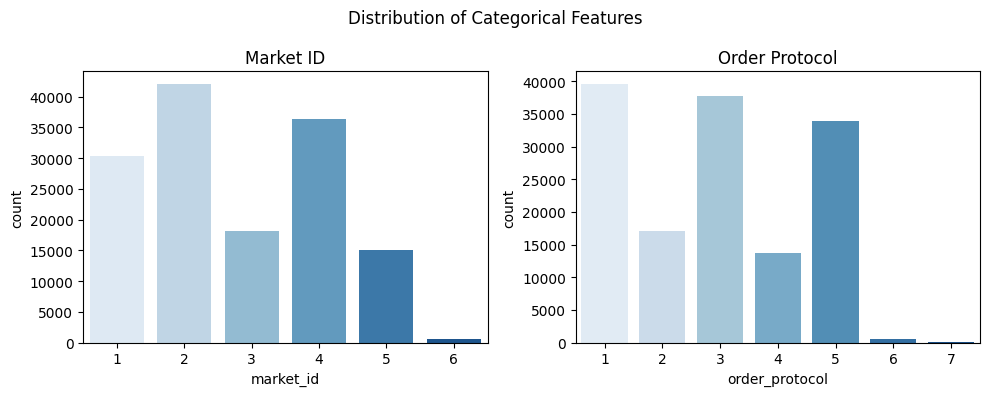

In [107]:
# Distribution of Categorical Features

fig, ax = plt.subplots(1,2, figsize=(10,4))
plt.suptitle('Distribution of Categorical Features')

sns.countplot(data=df, x='market_id', palette='Blues', ax=ax[0])
ax[0].set_title('Market ID')

sns.countplot(data=df, x='order_protocol', palette='Blues', ax=ax[1])
ax[1].set_title('Order Protocol')


plt.tight_layout()
plt.show()

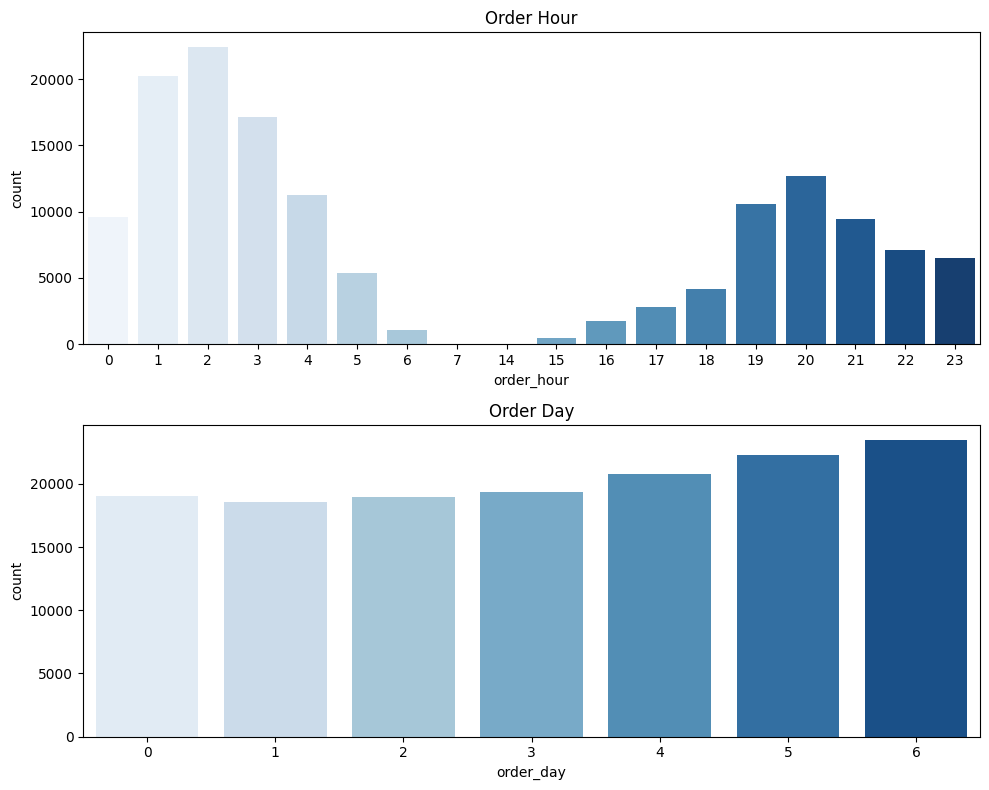

In [108]:
# Distribution of Categorical Features

fig, ax = plt.subplots(2,1, figsize=(10,8))

sns.countplot(data=df, x='order_hour', palette='Blues', ax=ax[0])
ax[0].set_title('Order Hour')

sns.countplot(data=df, x='order_day', palette='Blues', ax=ax[1])
ax[1].set_title('Order Day')


plt.tight_layout()
plt.show()

* Saturdays and Sundays have the highest order volume
* Highest volume of orders is between 1am-4am. There are no orders between 8 am to 2 pm

## Bivariate/Multivariate Analysis

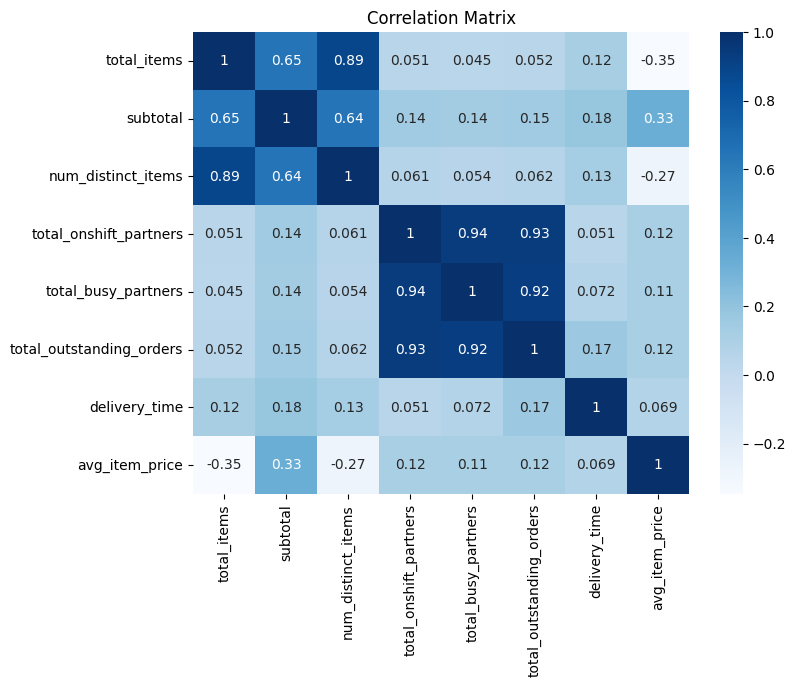

In [109]:
# Correlation Heatmap to show the relationship between different numerical features

numeric_cols = ['total_items', 'subtotal', 'num_distinct_items',
                  'total_onshift_partners','total_busy_partners',
                  'total_outstanding_orders', 'delivery_time','avg_item_price']

plt.figure(figsize=(8,6))
sns.heatmap(data=df[numeric_cols].corr(), annot=True, cmap=plt.cm.Blues)
plt.title('Correlation Matrix')
plt.show()

* `total_onshift_partners`, `total_busy_partners` and `total_outstanding_orders` have a high correlation.
* Similarly, `total_items`, `subtotal` and `num_distinct_items` also have a high correlation
* Our target variable, `delivery_time`, doesn't seem to have a strong correlation with any feature

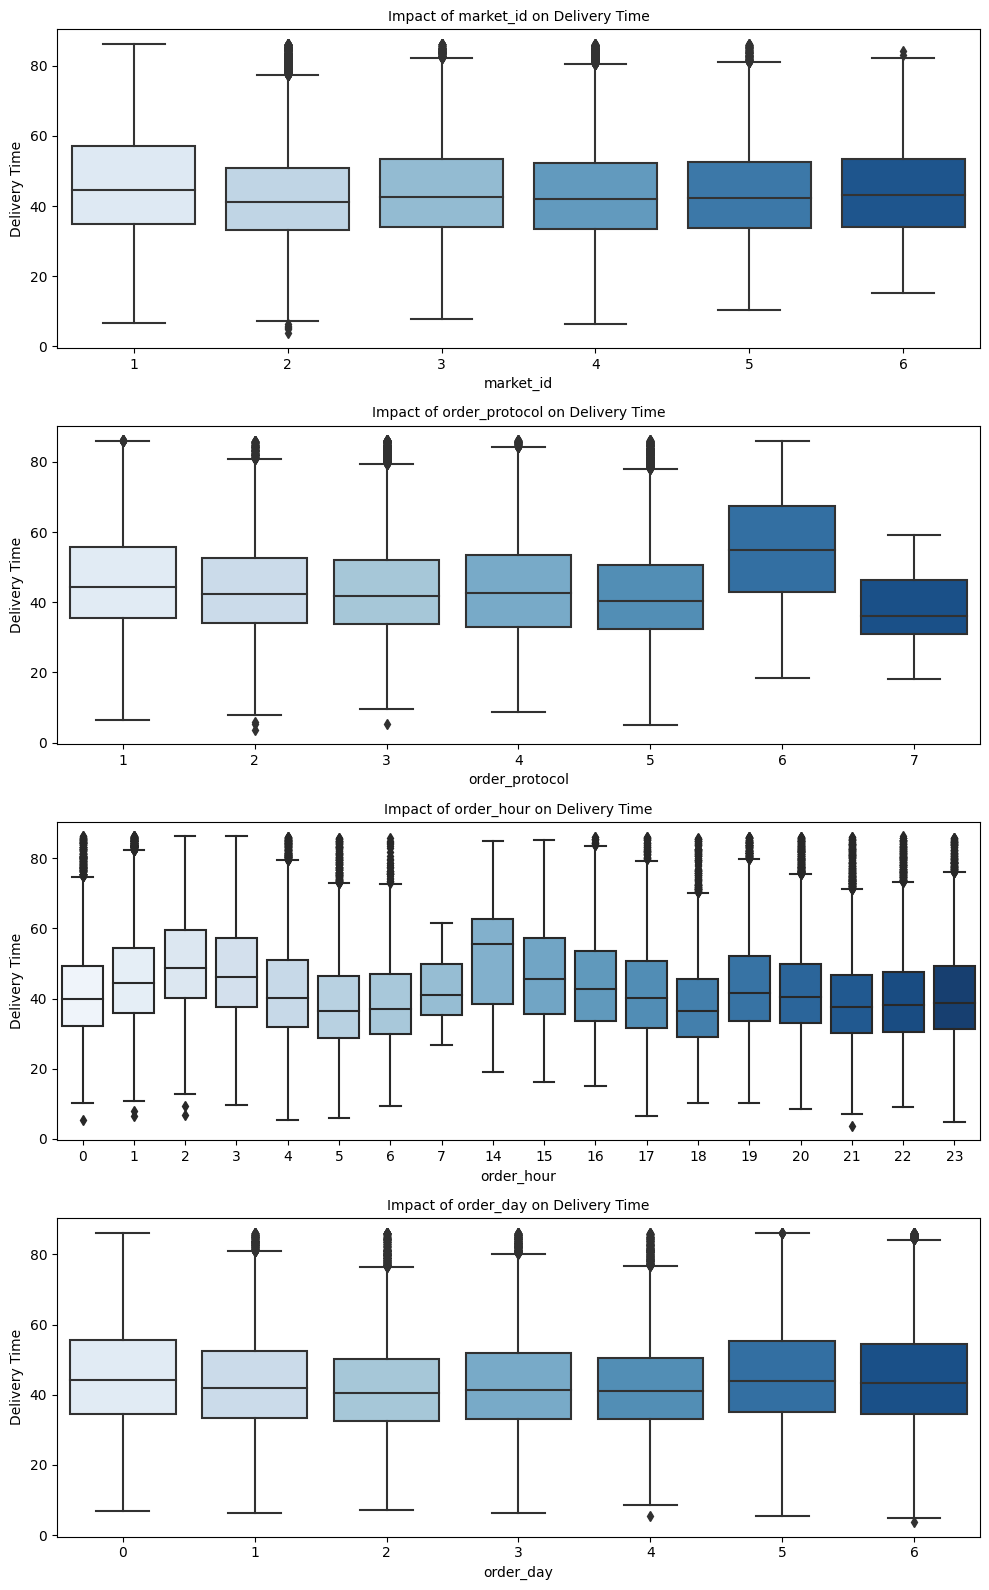

In [110]:
# Boxplots to analyse the relationship between categorical variables and delivery time

cat_cols = ['market_id','order_protocol','order_hour', 'order_day']

plt.figure(figsize=(10,16))
i=1
for col in cat_cols:
  ax = plt.subplot(4,1,i)
  sns.boxplot(data = df, x=col, y='delivery_time', palette='Blues')
  plt.title(f"Impact of {col} on Delivery Time", fontsize=10)
  plt.xlabel(col)
  plt.ylabel('Delivery Time')
  i+=1

plt.tight_layout()
plt.show();

* Market ID doesn't have an impact on the delivery time
* The delivery time for order protocol number 6 is relatively higher
* The delibery time at 2 pm is considerably higher than at other hours of the day
* The range of delivery time is higher on Mondays, Saturdays and Sundays (perhaps due to higher order volume on these days)

# Data Preparation

Lets separate the dataset from the target variable

In [111]:
X = df.drop(columns=['delivery_time'])
y = df['delivery_time']

print(X.shape, y.shape)

(142433, 12) (142433,)


Encoding of categorical columns using **one-hot encoding**

In [112]:
cat_cols = ['market_id', 'order_protocol', 'order_hour', 'order_day']
enc = OneHotEncoder(handle_unknown='ignore')
X_encoded = pd.DataFrame(enc.fit_transform(X[cat_cols]).toarray(), columns=enc.get_feature_names_out(cat_cols), index=X.index)
X_num = X.drop(cat_cols, axis=1)
X = pd.concat([X_num, X_encoded], axis=1)
X.head()

,store_primary_category,total_items,subtotal,num_distinct_items,total_onshift_partners,total_busy_partners,total_outstanding_orders,avg_item_price,market_id_1,market_id_2,...,order_hour_21,order_hour_22,order_hour_23,order_day_0,order_day_1,order_day_2,order_day_3,order_day_4,order_day_5,order_day_6
0,american,4,3441,4,33,14,21,898.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,mexican,1,1900,1,1,2,2,1400.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,indian,4,4771,3,8,6,18,1212.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
14,italian,1,1525,1,5,6,8,1525.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
17,italian,3,4375,3,6,4,3,1475.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Now we will **split the data** for training, validation and test

In [113]:
X_dev, X_test, y_dev, y_test = train_test_split(X,y,test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.1, random_state=42)

print('Train: ', X_train.shape, y_train.shape)
print('Val: ', X_val.shape, y_val.shape)
print('Test: ', X_test.shape, y_test.shape)

Train:  (115370, 46) (115370,)
Val:  (12819, 46) (12819,)
Test:  (14244, 46) (14244,)


**Target encoding** of `store_primary_category`

In [114]:
encoder = TargetEncoder(cols=['store_primary_category'])

X_train = encoder.fit_transform(X_train, y_train)
X_val = encoder.transform(X_val)
X_test = encoder.transform(X_test)

**Scaling** of numerical columns

**Scaling** of numerical columns

In [115]:
num_cols = ['store_primary_category', 'total_items', 'subtotal',
       'num_distinct_items', 'total_onshift_partners', 'total_busy_partners',
       'total_outstanding_orders', 'avg_item_price']

# Scaling the numeric features
scaler = MinMaxScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_val[num_cols] = scaler.transform(X_val[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Neural Network

In [116]:
# Defining NN model
tf.random.set_seed(40)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='linear')
])

In [117]:
# Compile the model
model.compile(loss='mse', optimizer=Adam(), metrics=['mae'])

# Model Training
history = model.fit(X_train, y_train, epochs=30, batch_size=512, verbose=1, validation_data=(X_val, y_val))

Epoch 1/30
226/226 [==============================] - 4s 9ms/step - loss: 324.1564 - mae: 13.4761 - val_loss: 176.9053 - val_mae: 10.5645
Epoch 2/30
226/226 [==============================] - 2s 8ms/step - loss: 177.0724 - mae: 10.5593 - val_loss: 166.9783 - val_mae: 10.3053
Epoch 3/30
226/226 [==============================] - 2s 7ms/step - loss: 168.4854 - mae: 10.2953 - val_loss: 164.7719 - val_mae: 10.0258
Epoch 4/30
226/226 [==============================] - 2s 9ms/step - loss: 164.9325 - mae: 10.1610 - val_loss: 159.8173 - val_mae: 10.1007
Epoch 5/30
226/226 [==============================] - 1s 6ms/step - loss: 163.8776 - mae: 10.1297 - val_loss: 158.9964 - val_mae: 9.9330
Epoch 6/30
226/226 [==============================] - 1s 6ms/step - loss: 162.3618 - mae: 10.0771 - val_loss: 157.9559 - val_mae: 9.9233
Epoch 7/30
226/226 [==============================] - 1s 5ms/step - loss: 161.7435 - mae: 10.0592 - val_loss: 157.7775 - val_mae: 9.9162
Epoch 8/30
226/226 [=================

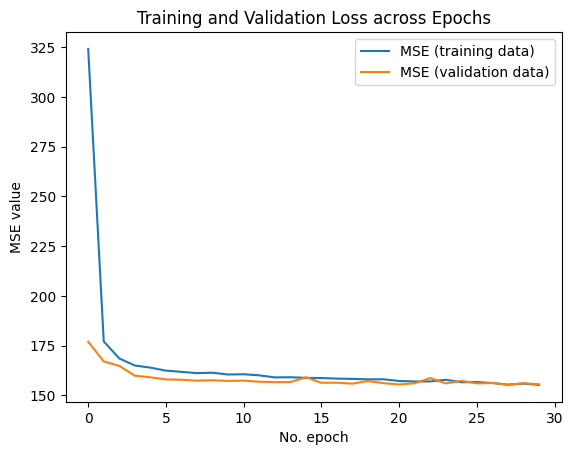

In [118]:
# Visualisation of epoch-wise progress

plt.plot(history.history['loss'], label='MSE (training data)')
plt.plot(history.history['val_loss'], label='MSE (validation data)')
plt.title('Training and Validation Loss across Epochs')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc='upper right')
plt.show()

In [119]:
model.evaluate(X_val, y_val, batch_size=512)

26/26 [==============================] - 0s 3ms/step - loss: 155.4654 - mae: 9.8849


[155.46539306640625, 9.884854316711426]

* It can be observed that there is not much change in the validation loss after 15 epochs
* Use of dropout layers has prevented the model from overfitting
* We have achieved an MSE of 155 and MAE of 9.8 on the validation data

In [120]:
# Prediction on test data and metric evaluation

y_pred = model.predict(X_test)
mse, mae = model.evaluate(X_test, y_test)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')

446/446 [==============================] - 1s 2ms/step - loss: 152.9288 - mae: 9.7521
Mean Squared Error (MSE): 152.92881774902344
Mean Absolute Error (MAE): 9.752063751220703


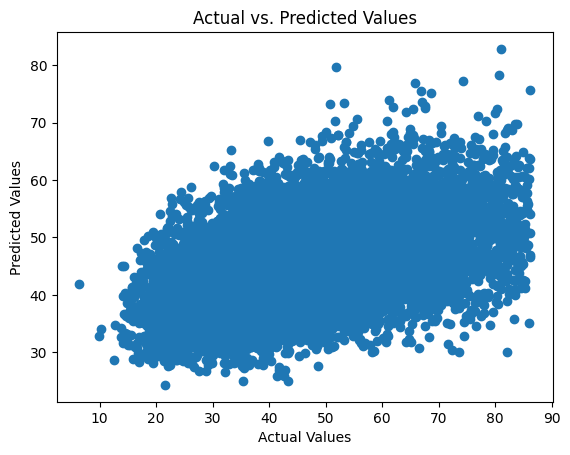

In [121]:

#Plotting actual v/s predicted values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

# Conclusion

We can observe that on an average, actual values are higher than predicted values. There is scope for improvement in the model. Suggestions for improvement:
* Hyperparameter tuning with respect to number of epochs, learning rate, number of neurons in each layer, number of layers etc
* Try different optimisers and activation functions
* Try classical ML models (since the dataset is not large enough for a neural network to learn enough) like Random Forrest and XGBoost
* Get more data relevant to delivery time such as distance between the pickup and delivery locations

**Questions:**
1. Defining the problem statements and where can this and modifications of this be used?  
**Problem Statement:** Porter is India's Largest Marketplace for Intra-City Logistics. The company works with restaurants for food delivery. It wants to give its customers an accurate estimate of the delivery time based on factors like the order time, items ordered, availability of delivery partners, number of outstanding orders and the type of restaurant. We need to build a regression model to predict the delivery time as accurately as possible based on these features.


2. List 3 functions the pandas datetime provides with one line explanation.  
**pd.to_datetime():** Converts the input to a datetime object. It can parse a wide variety of formats and return a datetime object
**df[col].dt.month:** It provides access to various components of the datetime (e.g., year, month, day, etc.) for each element in the column.
**date_range():** It is useful for creating a range of datetime values based on specified start and end dates, along with a frequency parameter.


3. Short note on datetime, timedelta, time span (period)  
**Datetime** is a data type in Python that represents data which has dates/time. It combines date and time information and allows for various operations and manipulations. Eg: current_time = datetime.now()
**Timedelta** is a duration expressing the difference between two dates or times. It represents a duration, not a specific point in time. Eg: duration = timedelta(days=5, hours=3)  
A **time span or period** represents a length of time, such as a day, a month, or a year. It's different from a specific point in time or a duration - used for frequency based calculations. Eg: period = pd.Period('2023-12', 'M')


4. Why do we need to check for outliers in our data?  
We need to check for outliers in our data for following reasons:  
* Due to outliers, scaling techniques such as standardisation or MinMaxScaler are impacted and result in wrong representation of the data for training  
* Outliers can significantly impact descriptive statistics of the data like mean, standard deviation and correlation. This can cause the data to be misrepresented  
* Outliers disproportionately influence the weights and biases while model training leading to overfitting. Outliers in training data make it difficult for the model to generalise well on test data.  


5. Name 3 outlier removal methods?  
IQR (inter quartile range method), z-score method, standard deviation method  


6. What classical machine learning methods can we use for this problem?  
For a regression problem, we can use classical ML methods like linear regression, Random Forests, XGBoost etc  


7. Why is scaling required for neural networks?  
* The ability of gradient descent to converge on the global minimum of the loss function, and as a result arrive at the optimal model parameters is improved drastically when the features are all on the same scale.  
* When the features are scaled, it helps in avoiding very large or very small gradients, in turn stabilising the process of gradient descent  
* If different features have different scales, the trained model might get biased to give more importance to features with higher values. Scaled features prevent such imbalances  


8. Briefly explain your choice of optimizer.   
Adam was chosen as the optimizer because it is an integration of Momentum and RMSProp:  
Adam combines the concepts of momentum and RMSProp. It uses the moving averages of past gradients (momentum) and past squared gradients (RMSProp) to adaptively scale the learning rates. This combination often results in improved convergence compared to using either method alone.  


9. Which activation function did you use and why?  
Rectified Linear Unit (ReLU) is a popular activation function in neural networks and deep learning models, and it has several advantages over other activation functions:  
* **Addressing the Vanishing Gradient Problem:**  
ReLU helps mitigate the vanishing gradient problem, which is common in activation functions like sigmoid and hyperbolic tangent (tanh). The vanishing gradient problem can impede the training of deep networks by making it difficult for gradients to propagate through many layers.  
* **Sparsity and Sparse Activation:**
ReLU introduces sparsity in the network as neurons that output zero for negative inputs are effectively inactive.   


10. Why does a neural network perform well on a large dataset?   
Neural networks often perform well on large datasets due to several key factors:
* **Improved Generalization:** Neural networks can learn more robust and generalizable patterns when exposed to a wide variety of examples, reducing the risk of overfitting to specific patterns present in smaller datasets.  
* **Increased Model Capacity:** Larger networks with more parameters have the capacity to learn complex relationships and representations within the data, capturing subtle patterns that may be missed with smaller datasets.  
* **Better Feature Representation:** Large datasets allow neural networks to automatically learn hierarchical and abstract features from the raw input data.   
* **Enhanced Model Training:** Neural networks often rely on iterative optimization algorithms, such as stochastic gradient descent. Large datasets provide more diverse examples for the optimization process, leading to more stable and effective model training.  
* **Improved Regularization:** The sheer volume of data acts as a form of implicit regularization, preventing the model from memorizing noise or outliers in the training set.  
